## Experiment on Toy Dataset 
### 1-Produce Synthetic Data
a input matrix with 2 NDs and 3 EDs, each entry is in [0, 100]

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1234)
n_rows = 5000
n_cols = 5

In [2]:
avg_scale = [50, 60, 5, 1, 0.5]
std = [10, 5] # for the first two data sets
seed = 1234

def toy_data(n_rows):
    X = pd.DataFrame()
    X['0']=5*np.random.randn(n_rows) + avg_scale[0]
    X['1']=3*np.random.randn(n_rows)+ avg_scale[1]
    X['2'] = np.random.exponential(avg_scale[2], n_rows)
    X['3'] = np.random.exponential(avg_scale[3], n_rows)
    X['4'] = np.random.exponential(avg_scale[4], n_rows)
    return X

X=toy_data(n_rows)

### 2-EDA
plot the histogram of each column, and pairwise scatter

           0          1          2         3         4
0  52.357176  64.133134   5.561230  1.095523  0.036809
1  44.045122  60.056503  10.960091  3.071213  0.040940
2  57.163535  57.597563   3.909378  0.374530  0.389914
3  48.436741  63.948000  14.503116  1.631933  1.239429
4  46.397056  64.136457   0.716654  0.162555  0.300746
                 0            1            2            3            4
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000
mean     50.121387    60.023927     5.052439     1.018470     0.494685
std       4.959370     2.995820     5.118079     1.036181     0.485752
min      30.595508    48.423994     0.000770     0.000323     0.000188
25%      46.770588    58.052108     1.447938     0.278106     0.149229
50%      50.133399    60.032293     3.516846     0.685685     0.337993
75%      53.465828    62.018851     6.830077     1.405968     0.689226
max      66.102842    69.863364    62.690185     9.297459     3.962922


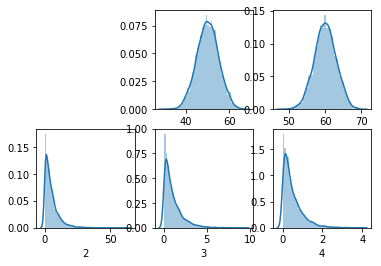

In [3]:
import seaborn as sns

# EDA
print(X.head(5))

print(X.describe())  # check if outliers exist

# plt.subplot(231)
# sns.distplot(y)
plt.subplot(232)
sns.distplot(X['0'])
plt.subplot(233)
sns.distplot(X['1'])
plt.subplot(234)
sns.distplot(X['2'])
plt.subplot(235)
sns.distplot(X['3'])
plt.subplot(236)
sns.distplot(X['4'])
plt.show()

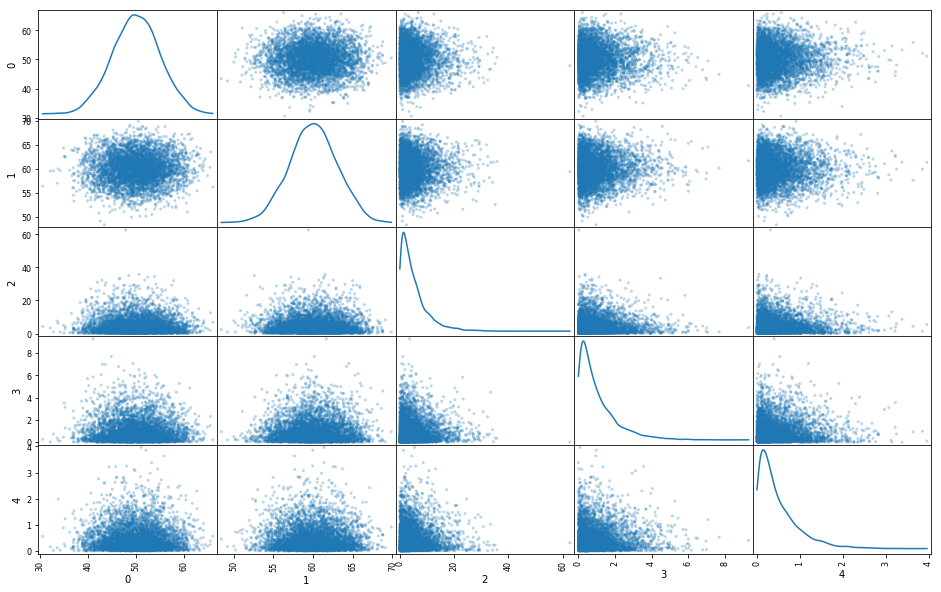

In [4]:
ax = pd.plotting.scatter_matrix(X, alpha = 0.3, figsize = (16,10), diagonal = 'kde');
plt.show()

### 2-Construct performance matrix
use CDF to give individual score, 
%consider 2 NDs are already transformed to scores

In [5]:
import scipy.stats as st
import pandas as pd

P = pd.DataFrame()

for j in range(2):
    args = st.norm.fit(X[str(j)])
    P[str(j)] = (1-st.norm.cdf(X[str(j)].values, *args)) * 100
for j in range(2, 5):
    args = st.expon.fit(X[str(j)])
    P[str(j)] = (1-st.expon.cdf(X[str(j)],*args))*100 # [st.expon.cdf(x,args) * 100 for x in X[str(j)]]
print(P.head(5))
print(P.describe())

           0          1          2          3          4
0  32.604295   8.506534  33.262869  34.107277  92.862531
1  88.977486  49.566164  11.423842   4.899198  92.090036
2   7.778777  79.102913  46.128746  69.244242  45.473088
3  63.296763   9.510125   5.665176  20.139265   8.160865
4  77.368679   8.489279  86.786963  85.270820  54.457672
                 0            1            2            3            4
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000
mean     49.932148    49.920817    50.051184    50.507119    49.715234
std      28.921447    28.903172    28.777731    29.339972    28.606083
min       0.063472     0.051042     0.000408     0.010823     0.033117
25%      25.001717    25.271544    25.874688    25.143657    24.826051
50%      49.903358    49.888577    49.856087    51.010769    50.506758
75%      75.039005    74.481305    75.090499    76.122448    73.980281
max      99.995884    99.994612   100.000000   100.000000    99.999999


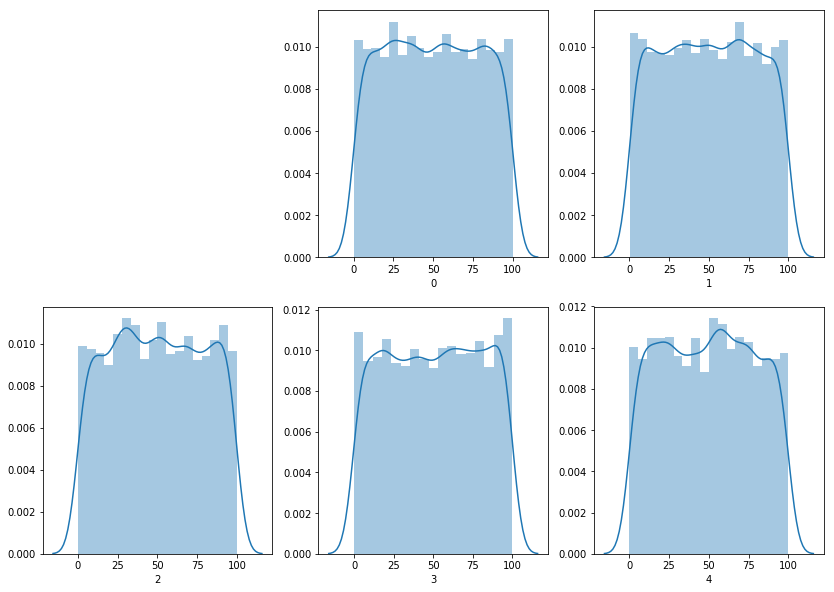

In [13]:
import seaborn as sns
plt.figure(figsize=(14,10))
plt.subplot(232)
sns.distplot(P['0'])
plt.subplot(233)
sns.distplot(P['1'])
plt.subplot(234)
sns.distplot(P['2'])
plt.subplot(235)
sns.distplot(P['3'])
plt.subplot(236)
sns.distplot(P['4'])
plt.show()

### 3-Compute weight
use Entropy Weighted method

In [7]:
import math

def EW(x, n, maxval, minval):
    x = (x - minval)/(maxval - minval)
    s = np.sum(x)
    tmp = np.sum([e/s * math.log(e/s+ 1e-6) for e in x])
#     print(tmp, math.log(n))
    p = - tmp / math.log(n)
#     print(p)
    d = 1 - p
#     print(d)
    return d

col_max = X.max(axis=0).values
col_min = X.min(axis=0).values

D = [EW(X[str(j)], n_rows, col_max[j], col_min[j]) for j in range(n_cols)]

In [8]:
def scale(D):
    s = np.sum(D)
    D /= s
    return D

w = scale(D)
print(w, np.sum(w))

[0.02814115 0.02906046 0.31467918 0.32432913 0.30379009] 1.0


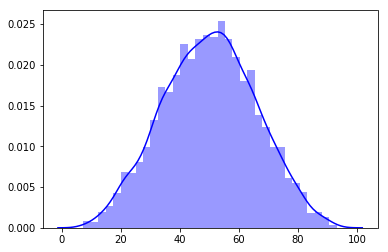

In [9]:
import seaborn as sns
ew_score = np.dot(P, w)

sns.distplot(ew_score, label='weighted sum score', color='b', kde=True)
plt.show()

### 4-Output Validation
first fit the mean and std from y_hat, then compare the distribution of y_hat to the ground true N(mean, std) with
K-S test and Anderson-Darling test

Kolmogorov-Smirnov test performs a test of the distribution G(x) of an observed random variable against a given distribution F(x). Under the null hypothesis the two distributions are identical, G(x)=F(x). The alternative hypothesis can be either ‘two-sided’ (default), ‘less’ or ‘greater’. The KS test is only valid for continuous distributions.


The Anderson-Darling test is a modification of the Kolmogorov- Smirnov test kstest for the null hypothesis that a sample is drawn from a population that follows a particular distribution. For the Anderson-Darling test, the critical values depend on which distribution is being tested against. This function works for normal, exponential, logistic, or Gumbel (Extreme Value Type I) distributions.
Critical values provided are for the following significance levels:

normal/exponenential
15%, 10%, 5%, 2.5%, 1%
logistic
25%, 10%, 5%, 2.5%, 1%, 0.5%
Gumbel
25%, 10%, 5%, 2.5%, 1%

(50.08986030953644, 15.73603256821126)
SkewtestResult(statistic=-0.2814457139196932, pvalue=0.7783685598278136)
KurtosistestResult(statistic=-7.5269696170079605, pvalue=5.193144796058218e-14)


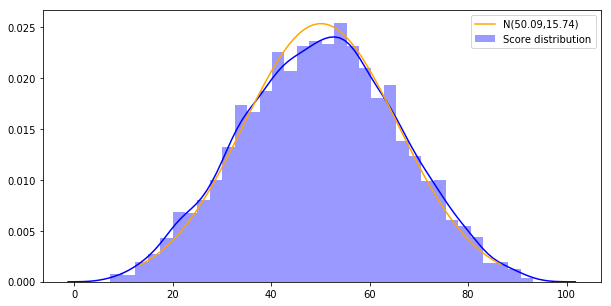

KstestResult(statistic=0.014458011514253521, pvalue=0.2468225017625343)
AndersonResult(statistic=1.9055150116573714, critical_values=array([0.576, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


In [10]:
from scipy import stats

y_hat = ew_score

(u,std) = stats.norm.fit(y_hat)
print((u,std))
print(stats.skewtest(y_hat))
print(stats.kurtosistest(y_hat))
plt.figure(figsize=(10,5))#绘制画布
sns.distplot(ew_score, label='weighted sum score', color='b', kde=True)
normalDistribution = stats.norm(u, std)
x = np.linspace(normalDistribution.ppf(0.01), normalDistribution.ppf(0.99), 100)
plt.plot(x, normalDistribution.pdf(x), c='orange')
plt.legend(['N({:.2f},{:.2f})'.format(u, std), 'Score distribution'] )
plt.show()


print(stats.kstest(y_hat, 'norm', (u, std)))

print(stats.anderson(y_hat, 'norm'))

### Clustering
cluster X into k groups

In [ ]:
from sklearn import mixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def get_score(name, estimator, clusterInput, compareInput=None):
    estimator.fit(clusterInput)
    labels = estimator.predict(clusterInput)
    if compareInput is None:
        silhouette_avg = silhouette_score(clusterInput, labels, metric='euclidean')
        ch = calinski_harabasz_score(clusterInput, labels)
        dbs = davies_bouldin_score(clusterInput, labels)
    else:
        silhouette_avg = silhouette_score(compareInput, labels, metric='euclidean')
        ch = calinski_harabasz_score(compareInput, labels)
        dbs = davies_bouldin_score(compareInput, labels)
    print("%s\t%.3f\t%.3f\t%.3f" %(name, silhouette_avg, ch, dbs))
    return labels


def cluster_validation(n_digit, clusterInput, compareInput, score_vec=None):
    print("methods  silhouette_score  calinski_harabasz_score  davies_bouldin_score")
    # # Fit a kmeans clustering model
    kmeans = KMeans(init='k-means++', n_clusters=n_digit, max_iter=3000, tol=1e-4, n_init=10, random_state=0)
    labels = get_score("kmeans", kmeans, clusterInput, compareInput)
    if score_vec is not None:
        tmp = pd.DataFrame({'label':labels, 'score':score_vec})
        print(tmp.groupby('label')['score'].describe())
    # Fit a Gaussian mixture with EM using five components
    gmm = mixture.GaussianMixture(n_components=n_digit, max_iter=3000, tol=1e-4, covariance_type='spherical', random_state=0)
    labels = get_score("GMM", gmm, clusterInput, compareInput)
    if score_vec is not None:
        tmp = pd.DataFrame({'label':labels, 'score':score_vec})
        print(tmp.groupby('label')['score'].describe())
    # # Fit a Dirichlet process Gaussian mixture using five components
    dpgmm = mixture.BayesianGaussianMixture(n_components=n_digit, max_iter=3000, tol=1e-4,
                                            covariance_type='spherical', random_state=0)
    labels = get_score("DPGMM", dpgmm, clusterInput, compareInput)
    if score_vec is not None:
        tmp = pd.DataFrame({'label':labels, 'score':score_vec})
        print(tmp.groupby('label')['score'].describe())

In [ ]:
## -------------- without score using only X then using labels to group ew_score----------------------
cluster_validation(3, X, X, ew_score)

# methods  silhouette_score  calinski_harabasz_score  davies_bouldin_score
# kmeans	0.299	2461.639	1.100
#         count       mean        std        min        25%        50%  \
# label                                                                  
# 0      2154.0  52.907755  15.082097  10.017224  42.270790  53.179337   
# 1       696.0  36.689585  13.034603   7.320000  27.276213  36.312764   
# 2      2150.0  51.602789  14.996510  12.046645  40.842422  51.461056   

#              75%        max  
# label                        
# 0      63.308941  93.197493  
# 1      46.020347  69.060613  
# 2      62.515947  91.589140  
# GMM	0.293	2387.765	1.116
#         count       mean        std        min        25%        50%  \
# label                                                                  
# 0      2118.0  53.039073  15.077286  10.017224  42.375398  53.318635   
# 1       751.0  37.025234  13.176220   7.320000  27.451469  36.400323   
# 2      2131.0  51.760931  14.919422  12.046645  41.138931  51.575783   

#              75%        max  
# label                        
# 0      63.605918  93.197493  
# 1      46.727875  69.060613  
# 2      62.561721  91.589140  
# DPGMM	0.293	2380.529	1.117
#         count       mean        std        min        25%        50%  \
# label                                                                  
# 0      2112.0  53.058924  15.075040  10.017224  42.471975  53.341862   
# 1       756.0  37.074357  13.203451   7.320000  27.526095  36.421986   
# 2      2132.0  51.762003  14.916003  12.046645  41.139790  51.579966   

#              75%        max  
# label                        
# 0      63.614569  93.197493  
# 1      46.710975  74.203594  
# 2      62.559709  91.589140 

In [ ]:
from sklearn.preprocessing import StandardScaler
input = StandardScaler().fit_transform(X)
cluster_validation(3, input)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
input = MinMaxScaler().fit_transform(X)
cluster_validation(3, input)

# methods  silhouette_score  calinski_harabasz_score  davies_bouldin_score
# kmeans	0.180	1050.390	1.875
#         count       mean        std      min        25%        50%        75%  \
# label                                                                           
# 0      1656.0  50.201116  16.001441  7.32000  39.248454  50.909155  61.508672   
# 1      1628.0  51.354383  15.688920  8.75742  40.051968  51.274093  62.614629   
# 2      1716.0  48.780460  15.430307  8.81832  37.655361  48.837773  59.026729   

#              max  
# label             
# 0      90.541940  
# 1      93.197493  
# 2      91.589140  
# GMM	0.022	220.166	4.133
#         count       mean        std        min        25%        50%  \
# label                                                                  
# 0      1557.0  55.986334  13.615873  22.020469  46.760227  55.577567   
# 1      1864.0  41.711397  15.087623   7.320000  31.073499  40.943192   
# 2      1579.0  54.163702  14.114794  17.683662  43.855568  54.071425   

#              75%        max  
# label                        
# 0      65.330275  93.197493  
# 1      52.047422  92.047458  
# 2      64.209396  89.912718  
# DPGMM	0.038	338.220	3.438
#         count       mean        std        min        25%        50%  \
# label                                                                  
# 0      1646.0  55.036476  13.727326  21.303039  45.024238  54.976883   
# 1      2016.0  42.090604  15.142980   7.320000  31.472153  41.366777   
# 2      1338.0  56.054228  13.652694  19.623854  46.438642  55.720509   

#              75%        max  
# label                        
# 0      64.544671  93.197493  
# 1      52.047422  92.047458  
# 2      65.679527  90.541940

In [ ]:
# add score as additional feature
X_hat = X
X_hat['score'] = ew_score
# print(X_hat.shape)
# print(X_hat.head(5))

cluster_validation(3, X_hat, X, ew_score)

# methods  silhouette_score  calinski_harabasz_score  davies_bouldin_score
# kmeans	0.350	5390.635	0.936
#         count       mean       std        min        25%        50%  \
# label                                                                 
# 0      1449.0  31.278450  7.434329   7.320000  26.645663  32.886908   
# 1      1336.0  69.618727  7.129241  59.656734  63.836437  68.092716   
# 2      2215.0  50.614970  5.515780  39.812464  45.845354  50.710602   

#              75%        max  
# label                        
# 0      37.185551  51.285959  
# 1      73.985681  93.197493  
# 2      55.174325  61.510188  
# GMM	0.342	5249.909	0.944
#         count       mean       std        min        25%        50%  \
# label                                                                 
# 0      1243.0  70.288482  6.940372  60.821170  64.597447  68.861169   
# 1      1726.0  33.145538  8.120962   7.320000  28.083890  34.584040   
# 2      2031.0  52.125786  5.130948  41.841651  47.886100  52.223678   

#              75%        max  
# label                        
# 0      74.423539  93.197493  
# 1      39.491321  57.825744  
# 2      56.406744  61.622366  
# DPGMM	0.342	5244.028	0.944
#         count       mean       std        min        25%        50%  \
# label                                                                 
# 0      1235.0  70.345894  6.925919  60.821170  64.674489  68.916124   
# 1      1745.0  33.249356  8.137694   7.320000  28.147452  34.679253   
# 2      2020.0  52.251459  5.093924  42.062637  48.112193  52.415846   

#              75%        max  
# label                        
# 0      74.502907  93.197493  
# 1      39.562999  57.825744  
# 2      56.485489  61.622366

In [ ]:
from sklearn.preprocessing import MinMaxScaler
input = MinMaxScaler().fit_transform(X_hat)
cluster_validation(3, input, X, ew_score)

# methods  silhouette_score  calinski_harabasz_score  davies_bouldin_score
# kmeans	0.180	1050.390	1.875
#         count       mean        std      min        25%        50%        75%  \
# label                                                                           
# 0      1656.0  50.201116  16.001441  7.32000  39.248454  50.909155  61.508672   
# 1      1628.0  51.354383  15.688920  8.75742  40.051968  51.274093  62.614629   
# 2      1716.0  48.780460  15.430307  8.81832  37.655361  48.837773  59.026729   

#              max  
# label             
# 0      90.541940  
# 1      93.197493  
# 2      91.589140  
# GMM	0.022	220.166	4.133
#         count       mean        std        min        25%        50%  \
# label                                                                  
# 0      1557.0  55.986334  13.615873  22.020469  46.760227  55.577567   
# 1      1864.0  41.711397  15.087623   7.320000  31.073499  40.943192   
# 2      1579.0  54.163702  14.114794  17.683662  43.855568  54.071425   

#              75%        max  
# label                        
# 0      65.330275  93.197493  
# 1      52.047422  92.047458  
# 2      64.209396  89.912718  
# DPGMM	0.038	338.220	3.438
#         count       mean        std        min        25%        50%  \
# label                                                                  
# 0      1646.0  55.036476  13.727326  21.303039  45.024238  54.976883   
# 1      2016.0  42.090604  15.142980   7.320000  31.472153  41.366777   
# 2      1338.0  56.054228  13.652694  19.623854  46.438642  55.720509   

#              75%        max  
# label                        
# 0      64.544671  93.197493  
# 1      52.047422  92.047458  
# 2      65.679527  90.541940

the p-value is greater than the significance level (say 5%), then we cannot reject the hypothesis that the data come from the given distribution

### End of Test

In [58]:
from sklearn import mixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def get_score(name, estimator, X_hat, X=None):
    estimator.fit(X_hat)
    labels = estimator.predict(X_hat)
    if X is None:
        silhouette_avg = silhouette_score(X_hat, labels, metric='euclidean')
        ch = 0 #metrics.calinski_harabasz_score(X, labels)
        dbs = 0 #metrics.davies_bouldin_score(X, labels)
    else:
        silhouette_avg = silhouette_score(X, labels, metric='euclidean')
#         X_hat['label'] = labels
#         print(X_hat.groupby('label')['score'].describe())
        ch = 0 #metrics.calinski_harabasz_score(X, labels)
        dbs = 0 #metrics.davies_bouldin_score(X, labels)
    print("%s\t%.3f\t%.3f\t%.3f" %(name, silhouette_avg, ch, dbs))
    return labels

def cluster_validation(n_digit,X_hat, X=None, score_vec=None):
    print("methods  silhouette_score  calinski_harabasz_score  davies_bouldin_score")
    # # Fit a kmeans clustering model
    kmeans = KMeans(init='k-means++', n_clusters=n_digit, max_iter=3000, tol=1e-4, n_init=10, random_state=0)
    labels = get_score("kmeans", kmeans,X_hat, X)
    tmp = pd.DataFrame({'label':labels, 'score':score_vec})
    print(tmp.groupby('label')['score'].describe())
    # Fit a Gaussian mixture with EM using five components
    gmm = mixture.GaussianMixture(n_components=n_digit, max_iter=3000, tol=1e-4, covariance_type='spherical', random_state=0)
    labels = get_score("GMM", gmm,X_hat, X)
    tmp = pd.DataFrame({'label':labels, 'score':score_vec})
    print(tmp.groupby('label')['score'].describe())
    # # Fit a Dirichlet process Gaussian mixture using five components
    dpgmm = mixture.BayesianGaussianMixture(n_components=n_digit, max_iter=3000, tol=1e-4,
                                        covariance_type='spherical', random_state=0)
    labels = get_score("DPGMM", dpgmm,X_hat, X)
    tmp = pd.DataFrame({'label':labels, 'score':score_vec})
    print(tmp.groupby('label')['score'].describe())

In [44]:
X_hat = P
X_hat['score'] = ew_score
print(X_hat.shape)
print(X_hat.head(5))

(5000, 6)
           0          1          2          3          4      score
0  67.395705  91.493466  66.737131  65.892723   7.137469  49.095442
1  11.022514  50.433836  88.576158  95.100802   7.909964  62.895818
2  92.221223  20.897087  53.871254  30.755758  54.526912  46.694375
3  36.703237  90.489875  94.334824  79.860735  91.839135  87.148735
4  22.631321  91.510721  13.213037  14.729180  45.542328  26.066493


In [47]:
cluster_validation(3, X_hat, X)

methods  silhouette_score  calinski_harabasz_score  davies_bouldin_score
kmeans	0.161	0.000	0.000
GMM	0.120	0.000	0.000
DPGMM	0.071	0.000	0.000


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# from sklearn.decomposition import PCA
# X = PCA(2).fit_transform(P)

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(P)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(P, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(P, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
#     colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
#     ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
#                 c=colors, edgecolor='k')

#     # Labeling the clusters
#     centers = clusterer.cluster_centers_
#     # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
#                 c="white", alpha=1, s=200, edgecolor='k')

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                     s=50, edgecolor='k')

#     ax2.set_title("The visualization of the clustered data.")
#     ax2.set_xlabel("Feature space for the 1st feature")
#     ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

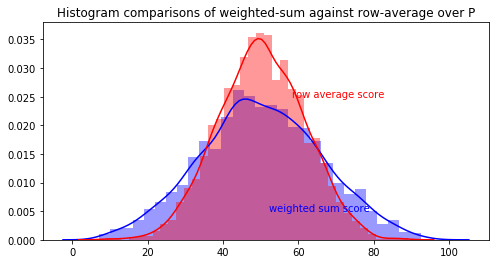

50.09285602503491 15.92171614386752
50.21684939891513 11.357833877416967


In [7]:
y = P.mean(axis=1)
y_hat = np.dot(P, w)

plt.figure(figsize=(8,4))#绘制画布
sns.distplot(y_hat, label='weighted sum score', color='b')
plt.text(np.mean(y_hat)+2,0.005,'weighted sum score', color = 'b')

sns.distplot(y, color='r', label='row average score')
plt.text(np.mean(y)+8,0.025,'row average score', color = 'r')

plt.title('Histogram comparisons of weighted-sum against row-average over P')
plt.show()
print(np.mean(y_hat), np.std(y_hat))
print(np.mean(y), np.std(y))

In [8]:
from scipy.stats import kstest, shapiro
from scipy.stats import normaltest
from scipy.stats import anderson

(u, std)=(np.mean(y_hat), np.std(y_hat))

In [21]:
print(shapiro(y_hat))

# print((u, std))
print(kstest(y_hat, 'norm', (u, std)))

print(normaltest(y_hat))

print(anderson(y_hat))

(0.9978645443916321, 0.00040872892714105546)
KstestResult(statistic=0.013488786553606358, pvalue=0.6460243555126054)
NormaltestResult(statistic=15.593581626605033, pvalue=0.00041105200718819933)
AndersonResult(statistic=0.6343228313871805, critical_values=array([0.575, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


In [10]:
print(shapiro(X['1']))
print(normaltest(X['1']))

(0.9984280467033386, 0.005290188826620579)
NormaltestResult(statistic=10.009022165426643, pvalue=0.0067076200180437315)


In [11]:
test1 =  shapiro(y)
print(test1)

test1 = kstest(y, 'norm', (50, np.std(y)))
print(test1)

test1 = normaltest(y)
print(test1)

test1 = anderson(y)
print(test1)

(0.9995035529136658, 0.662087619304657)
KstestResult(statistic=0.014833575540532773, pvalue=0.5239960452853454)
NormaltestResult(statistic=1.6048944209857074, pvalue=0.4482307059440612)
AndersonResult(statistic=0.2969889216683441, critical_values=array([0.575, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


[0.004530489646633162, 0.004678492028399206, 0.050660722603165564, 0.05221428469862366, 0.04890767044544231]


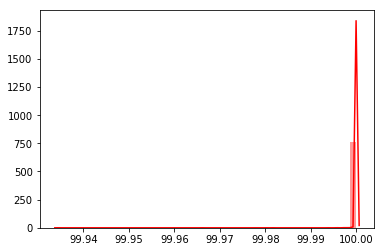

In [26]:
# not normalizing the diversity but rather take them as weights and use sigmoid activation function
def sigmoid(z):
    return 1/(1 + np.exp(-z))
print(D)
tmp = np.dot(P, D)

sigmoid_score = sigmoid(ew_score) * 100

sns.distplot(sigmoid_score, label='sigmoid score', color='r', kde=True)
plt.show()